In [66]:
import os,sys
from glob import glob
import urllib
import requests
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib
import fiona
import rasterio as rio
import earthpy as et

# helpers
from xarr_helpers import *

from pysptools.material_count.vd import HfcVd
import pysptools.eea as eea #endmembers extraction algorithms
import pysptools.abundance_maps as amap
import pysptools.classification as cls
import pysptools.material_count as cnt

from earthpy.spatial import bytescale

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
os.chdir(os.path.join(et.io.HOME,'earth-analytics'))

In [64]:
def open_woody_veg_structure(site, date):
    '''Uses API call to retrieve NEON product data for woody 
    vegetation structure. Returns pandas of merged apparent 
    individual, mapping and tagging, and per plot per year
    documents, eg one dataframe with locational, species, 
    and height data. Also returns a pandas dataframe of filtered 
    plot data to facilitate geospatial merges and calculation of
    raster stats. For more information on NEON woody vegetation 
    structure data products and available dates, see
    https://data.neonscience.org/data-products/DP1.10098.001
    
    Parameters
    ----------
    site : str
        4 Letter site name. See 
        https://www.neonscience.org/field-sites/field-sites-map/list
        for a full list of NEON sites
    
    date : str
        Date of data collection in yyyy-mm format
    
    Returns
    -------
    all_merged_df : pandas.core.frame.DataFrame
        Pandas dataframe of merged measurement, plot, and mapping
        tabular files from data product
    
    plot_df : pandas.core.frame.DataFrame
        Pandas dataframe of perplotperyear.csv locational data
    '''
    data_product_url = ['https://data.neonscience.org/api/v0/data/DP1.10098.001/'
                        + site+'/'+date]
    call_response = requests.get(data_product_url[0])    
    for i in call_response.json()['data']['files']:
        data_file_url = i['url']
        height_find = data_file_url.find('individual')
        map_find = data_file_url.find('mapping')
        if not height_find == -1:
            apparent_df = pd.read_csv(data_file_url)
        elif not map_find == -1:
            map_df = pd.read_csv(data_file_url)    
    apparent_df = apparent_df[[
        'plotID', 'individualID','height']] 
    map_df = map_df[['plotID', 'individualID', 'scientificName']]
    
    return apparent_df,map_df


In [2]:
# load the table mountain shapefile
point_file = r"../arc/headwall_neon_CUSouth_poi.shp"
gdf1 = gpd.read_file(point_file)
print('point CRS: {}'.format(gdf1.crs))


point CRS: {'init': 'epsg:32613'}


In [3]:
gdf = gdf1.drop(1).reset_index()
gdf_4326 = gdf.to_crs(epsg=4326)
gdf_4326.head()

index  Id              comments  \
0      0   0      dirt parking lot   
1      2   0  tennis court (south)   
2      3   0               red hut   
3      4   0   grass patch (south)   
4      5   0         leaf off tree   

                                       geometry  
0  POINT (-105.2320413087213 39.97927552633687)  
1  POINT (-105.2321048858712 39.97956622917603)  
2   POINT (-105.2320315564236 39.9796903363637)  
3  POINT (-105.2319140238961 39.97865502556768)  
4  POINT (-105.2320006579609 39.97880026728588)

In [47]:
# NEON data files
ONAQ_hyp_refl=glob(os.path.join('data','earthpy-downloads','*ONAQ_DP1*'))
neon_radiance_files = ONAQ_hyp_refl[0]

In [54]:
data_file_NEON = neon_radiance_files
data_file_ids=os.path.basename(data_file_NEON).split('_')
location_date = data_file_ids[2],data_file_ids[4]
neon_id=data_file_ids[2]
print('NEON ID: ', neon_id)

NEON ID:  ONAQ


In [56]:
# then NEON (dask chunking done in-function)
x_neon, y_neon, xarr_NEON = NEON_create_refl_xarr_from_h5_file(data_file_NEON, nid=neon_id)



C:\Users\17205\earth-analytics\neon-headwall-data\notebooks\xarr_helpers.py:75: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_str = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Coordinate_System_String'].value
C:\Users\17205\earth-analytics\neon-headwall-data\notebooks\xarr_helpers.py:76: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_epsg = f[nid]['Reflectance']['Metadata']['Coordinate_System']['EPSG Code'].value
C:\Users\17205\earth-analytics\neon-headwall-data\notebooks\xarr_helpers.py:77: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_mapinfo = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Map_Info'].value
C:\Users\17205\earth-analytics\neon-headwall-data\notebooks\xarr_helpers.py:78: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_proj4 = f[nid]['Reflectance']['Metadata']['Coordinate_System'

In [57]:
xarr_NEON.shape

(14043, 1506, 426)

In [67]:
# Master list of plotids with coords
url='https://data.neonscience.org/api/v0/documents/All_NEON_TOS_Plots_V7'
urllib.request.urlretrieve(url=url)
all_NEON_sites=gpd.read_file(url)
# Merge taxonomic data to the plotID coordinates
ONAQ_bnd=all_NEON_sites[all_NEON_sites['plotID'].str.match('ONAQ')]
ONAQ_bnd=ONAQ_bnd[['plotID','plotSize','geometry']]
ONAQ_bnd_rpj=ONAQ_bnd.to_crs('epsg:32612')
ONAQ_bnd_rpj['geometry'] = ONAQ_bnd_rpj.geometry.buffer(40)
measurement_df,taxonomic_df=open_woody_veg_structure('ONAQ','2019-08')
taxon_loc_df=pd.merge(ONAQ_bnd_rpj,taxonomic_df,on='plotID')



In [69]:
# subset the NEON data with the full extent of headwall data cubes
from shapely.geometry import mapping, box

# bbox = box(XMIN, YMIN, XMAX, YMAX)
chunk1 = taxon_loc_df

neon_sub_cube, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), chunk1)
neon_wav, full_neon = neon_arrs

# Estimate number of materials present in scene

In [102]:
# x = x[~numpy.isnan(x)]
# reshape_cube=(neon_sub_cube.values.reshape(neon_shp[0]*neon_shp[1], neon_shp[2]))
neon_sub_cube.values.reshape(neon_shp[0]*neon_shp[1], neon_shp[2]).shape

(648192, 426)

In [101]:
# HfcVd(reshape_cube[~np.isnan(reshape_cube)],far='default')
reshape_cube[~np.isnan(reshape_cube)].shape

(19853304,)

In [75]:
neon_shp = neon_sub_cube.values.shape
est_num_mats = HfcVd(neon_sub_cube.values.reshape(neon_shp[0]*neon_shp[1], neon_shp[2]), far='default')
est_num_mats

LinAlgError: Array must not contain infs or NaNs

# Auto-Extract 3, 4, and 5 endmembers. Then plot their abundance maps.

In [93]:
ee = eea.NFINDR()

for n_em in [3,4,5]:
    
    U = ee.extract(neon_sub_cube.values, n_em, maxit=10, normalize=False, ATGP_init=True)
    
    # plot them
    plt.figure(figsize=(20,10))
    for em in U:
        plt.plot(neon_wav, em)
        
    plt.title(f'Extracted {n_em} Endmembers from NEON Subset')
    plt.show()

    # Plot the abundance maps
    am = amap.FCLS()
    ab_maps = am.map(neon_sub_cube.values, U, normalize=False)
    
    for i,em in enumerate(U):
        fig = plt.figure(figsize=(20,8))
        gs = gridspec.GridSpec(1, 3, width_ratios=[8, 1, 1]) 

        ax0 = plt.subplot(gs[0])
        p0 = ax0.plot(neon_wav, em)
        ax0.grid(True)

        ax1 = plt.subplot(gs[1])
        im1 = ax1.imshow(bytescale(neon_sub_cube.values[:,:,[54, 34, 22]]))

        ax2 = plt.subplot(gs[2])
        im2 = ax2.imshow(ab_maps[:,:,i])


        divider = make_axes_locatable(ax2)
        cax = divider.append_axes("right", size="15%", pad=0.05)

        plt.colorbar(im2, cax=cax)
        plt.show()
        
    print('*****************************************************************************')
    print('*****************************************************************************')
    print('*****************************************************************************')
    print('*****************************************************************************')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Use spatial extraction to generate the endmember spectra, and plot the abundance maps

In [15]:
neon_pt_em, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), gdf)
# neon_wav, full_neon = neon_arrs

neon_pt_em.shape

(5, 4, 426)

In [16]:
ds_neon = xr.Dataset(coords={'y':y_neon, 'x':x_neon})
shapes = [(shape, n) for n, shape in enumerate(gdf.geometry)]

temp=[]
for shape in shapes:
    ds_neon['aoi'] = rasterize([shape], ds_neon.coords)
    ds_neon['aoi'] = ds_neon.aoi*0 + 1

    example_neon = ds_neon.aoi * xarr_NEON

    val_y, val_x = np.where(ds_neon.aoi==1)
    u_y = np.unique(val_y)
    u_x = np.unique(val_x)
    ex_neon = example_neon.sel(y=y_neon[val_y], x=x_neon[val_x])

    temp.append(np.squeeze(ex_neon))

neon_pt_em = np.vstack(temp)
neon_pt_em.shape

(5, 426)

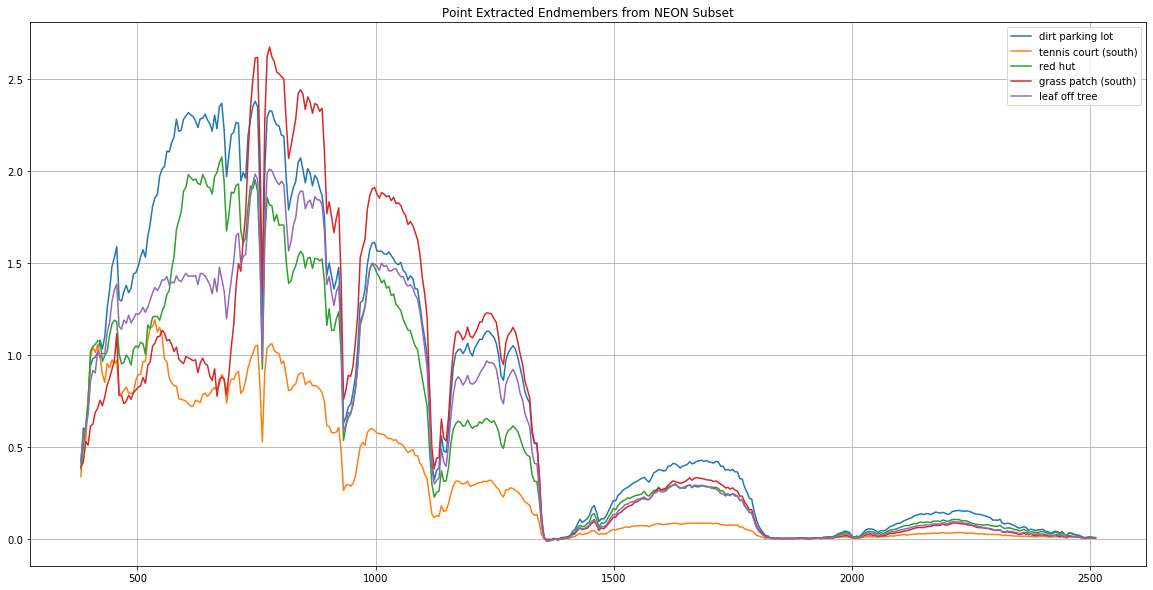

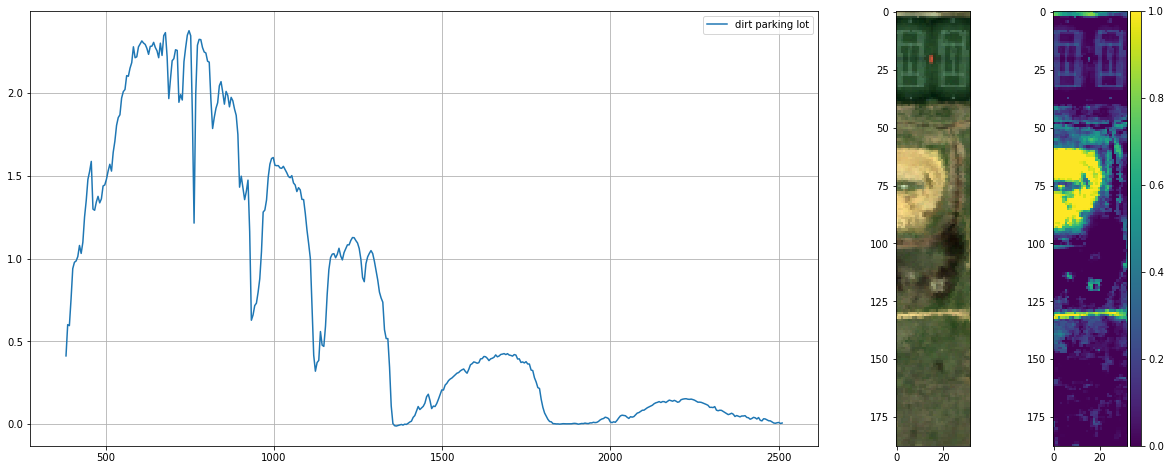

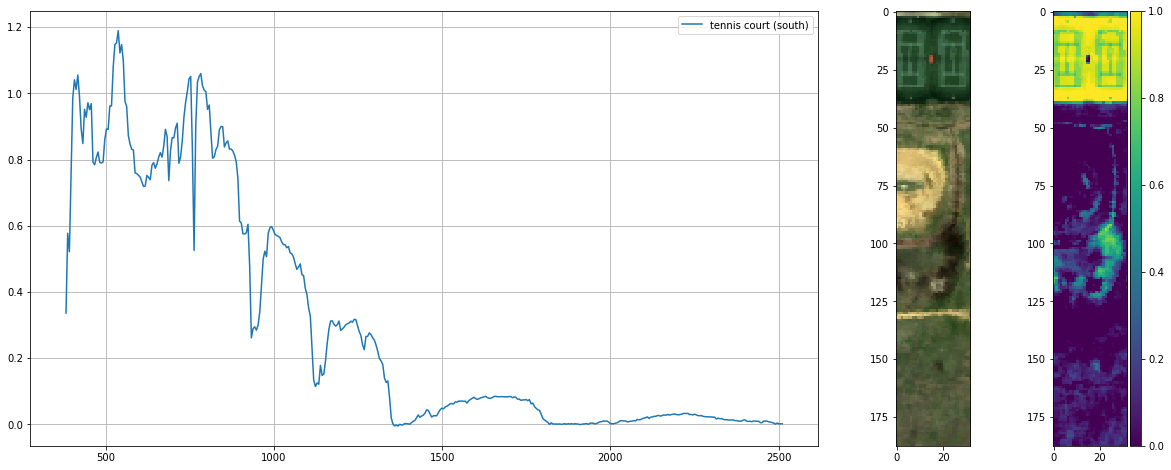

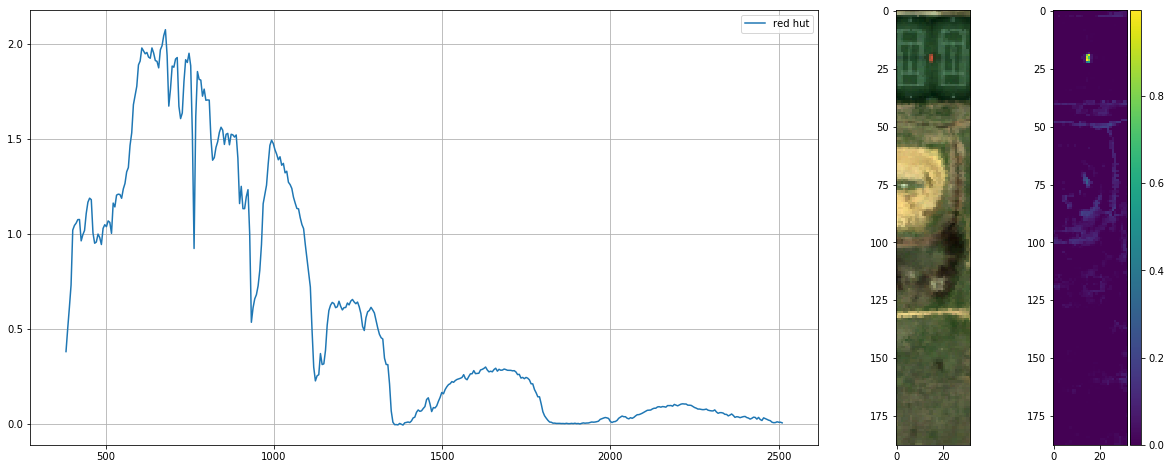

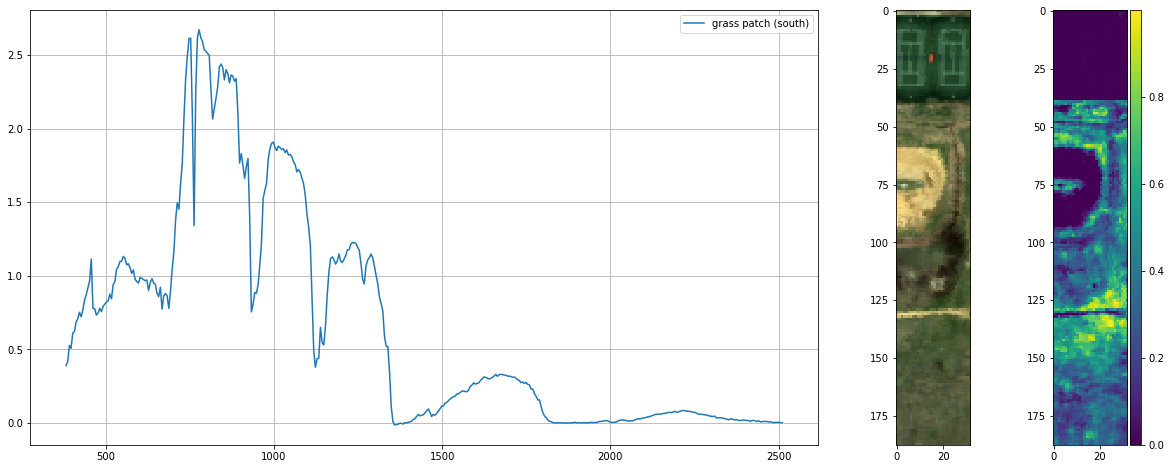

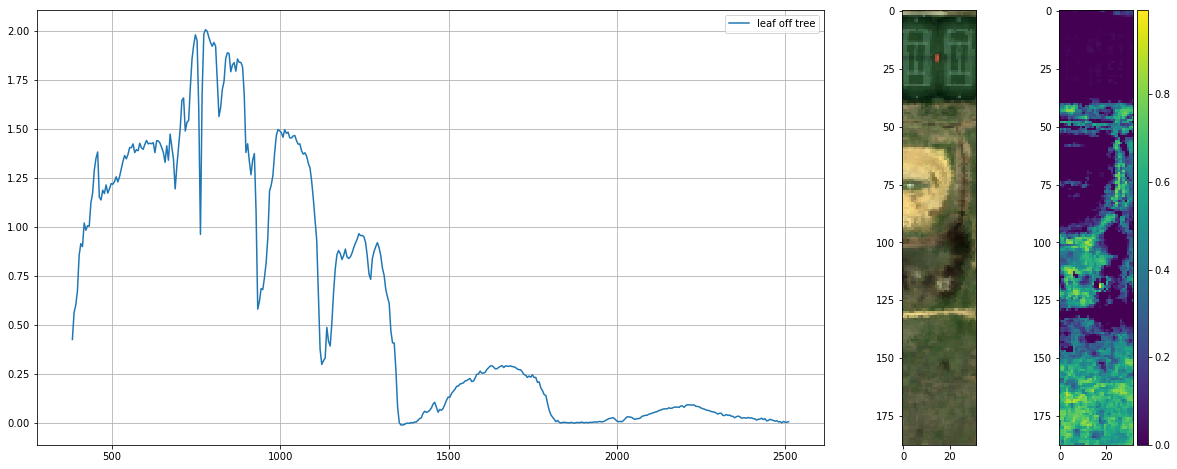

*****************************************************************************
*****************************************************************************
*****************************************************************************
*****************************************************************************


In [17]:
Ue = neon_pt_em
    
# plot them
plt.figure(figsize=(20,10))
for i, em in enumerate(Ue):
    plt.plot(neon_wav, em, label=gdf.comments[i])

plt.title(f'Point Extracted Endmembers from NEON Subset')
plt.legend()
plt.grid(True)
plt.show()

# Plot the abundance maps
am = amap.FCLS()
ab_maps = am.map(neon_sub_cube.values, Ue, normalize=False)

for i,em in enumerate(Ue):
    fig = plt.figure(figsize=(20,8))
    gs = gridspec.GridSpec(1, 3, width_ratios=[8, 1, 1]) 

    ax0 = plt.subplot(gs[0])
    p0 = ax0.plot(neon_wav, em, label=gdf.comments[i])
    ax0.legend()
    ax0.grid(True)

    ax1 = plt.subplot(gs[1])
    im1 = ax1.imshow(bytescale(neon_sub_cube.values[:,:,[54, 34, 22]]))

    ax2 = plt.subplot(gs[2])
    im2 = ax2.imshow(ab_maps[:,:,i])


    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="15%", pad=0.05)

    plt.colorbar(im2, cax=cax)
    plt.show()

print('*****************************************************************************')
print('*****************************************************************************')
print('*****************************************************************************')
print('*****************************************************************************')

# Try for Headwall

In [170]:
gdf_test = gdf_4326

def concat_hw_arrays(hw_pair, dim='band', w_cutoff=896):
    vn, sw = hw_pair
    
    # first check the array sizes, and shave off if needed
    if vn.shape != sw.shape:
        warnings.warn('extracted shapes are not equal, shaving some off...')
        
        min_shape = (min(vn.shape[0], sw.shape[0]), min(vn.shape[1], sw.shape[1]), min(vn.shape[2], sw.shape[2]))
        sw = sw[:min_shape[0], :min_shape[1], :min_shape[2]]
        vn = vn[:min_shape[0], :min_shape[1], :min_shape[2]]
        
    # next, check the x-y offsets. If needed, shift one or the other
    x_offset = np.mean(vn.coords['x'].values - sw.coords['x'].values).ravel()[0]
    y_offset = np.mean(vn.coords['y'].values - sw.coords['y'].values).ravel()[0]
    
#     print(x_offset, y_offset)
#     if (x_offset != 0):
#         sw.assign_coords(x= sw.coords['x'].values + x_offset)
        
#     if (y_offset !=0):
#         sw.assign_coords(y = sw.coords['y'].values + y_offset)
        
    if w_cutoff > 0:
        b_cutoff = np.where(vn.coords['wavelength'] <= w_cutoff)[0][-1] + 1 # +1 due to 1 based indexing on band
        vn = vn.sel(band=slice(0, b_cutoff))
        
    print(vn.shape, sw.shape)
    new_cube = xr.concat((vn,sw), dim=dim, join='left')
    
    return new_cube

def np_concat_hw_arrays(hw_pair, dim='band', w_cutoff=896):
    vn, sw = hw_pair
    
    # first check the array sizes, and shave off if needed
    if vn.shape != sw.shape:
        warnings.warn('extracted shapes are not equal, shaving some off...')
        
        min_shape = (min(vn.shape[0], sw.shape[0]), min(vn.shape[1], sw.shape[1]), min(vn.shape[2], sw.shape[2]))
        sw = sw[:min_shape[0], :min_shape[1], :min_shape[2]]
        vn = vn[:min_shape[0], :min_shape[1], :min_shape[2]]
        
    # next, check the x-y offsets. If needed, shift one or the other
    x_offset = np.mean(vn.coords['x'].values - sw.coords['x'].values).ravel()[0]
    y_offset = np.mean(vn.coords['y'].values - sw.coords['y'].values).ravel()[0]
    
#     print(x_offset, y_offset)
#     if (x_offset != 0):
#         sw.assign_coords(x= sw.coords['x'].values + x_offset)
        
#     if (y_offset !=0):
#         sw.assign_coords(y = sw.coords['y'].values + y_offset)
        
    if w_cutoff > 0:
        b_cutoff = np.where(vn.coords['wavelength'] <= w_cutoff)[0][-1] + 1 # +1 due to 1 based indexing on band
        vn = vn.sel(band=slice(0, b_cutoff))
        
    print(vn.shape, sw.shape)
    new_cube = np.concatenate((vn.values,sw.values))
    coords_dict = {'x': vn.coords['x'].values,
                   'y': vn.coords['y'].values,
                   'band': np.arange(1, new_cube.shape[0]+1)}
    attrs_dict = {'wavelength': np.concatenate((vn.coords['wavelength'].values, sw.coords['wavelength'].values))}
    
    return xr.DataArray(new_cube, dims=('band', 'y', 'x'), coords=coords_dict, attrs=attrs_dict)

def merge_hw_arrays(hw_pair, dim='band', w_cutoff=896):
    vn, sw = hw_pair
    
    # first check the array sizes, and shave off if needed
#     if vn.shape != sw.shape:
#         warnings.warn('extracted shapes are not equal, shaving some off...')
        
#         min_shape = (min(vn.shape[0], sw.shape[0]), min(vn.shape[1], sw.shape[1]), min(vn.shape[2], sw.shape[2]))
#         sw = sw[:min_shape[0], :min_shape[1], :min_shape[2]]
#         vn = vn[:min_shape[0], :min_shape[1], :min_shape[2]]
        
#     # next, check the x-y offsets. If needed, shift one or the other
#     x_offset = np.mean(vn.coords['x'].values - sw.coords['x'].values).ravel()[0]
#     y_offset = np.mean(vn.coords['y'].values - sw.coords['y'].values).ravel()[0]
    
#     if (x_offset != 0):
#         sw.assign_coords(x= sw.coords['x'].values - x_offset)
        
#     if (y_offset !=0):
#         sw.assign_coords(y = sw.coords['y'].values - y_offset)
        
    if w_cutoff > 0:
        b_cutoff = np.where(vn.coords['wavelength'] <= w_cutoff)[0][-1] + 1 # +1 due to 1 based indexing on band
        vn = vn.sel(band=slice(0, b_cutoff))
    
    #interpolate into the higher resolution grid from IMERG
    vn = vn.interp(x=sw["x"], y=sw["y"])
    new_cube = xr.concat([vn, sw])
    
    return new_cube

hw_cubes = [np_concat_hw_arrays(pair) for pair in zip(xarr_VNIR_ls, xarr_SWIR_ls)]
x_hw = [x.coords['x'] for x in hw_cubes]
y_hw = [x.coords['y'] for x in hw_cubes]

hw_cubes[0].coords, hw_cubes[0].shape, hw_cubes[0].coords['band'].shape, hw_cubes[0].attrs['wavelength'].shape

C:\software\anaconda3\envs\geo_py\lib\site-packages\ipykernel_launcher.py:39: UserWarning: extracted shapes are not equal, shaving some off...


(223, 559, 359) (270, 559, 359)


C:\software\anaconda3\envs\geo_py\lib\site-packages\ipykernel_launcher.py:39: UserWarning: extracted shapes are not equal, shaving some off...


(223, 593, 340) (270, 593, 340)


C:\software\anaconda3\envs\geo_py\lib\site-packages\ipykernel_launcher.py:39: UserWarning: extracted shapes are not equal, shaving some off...


(223, 617, 324) (270, 617, 324)


(Coordinates:
   * x        (x) float64 -105.2 -105.2 -105.2 -105.2 ... -105.2 -105.2 -105.2
   * y        (y) float64 39.98 39.98 39.98 39.98 ... 39.98 39.98 39.98 39.98
   * band     (band) int32 1 2 3 4 5 6 7 8 9 ... 486 487 488 489 490 491 492 493,
 (493, 559, 359),
 (493,),
 (493,))

In [201]:
neon_sub_cube.shape

(188, 32, 426)

In [128]:
plt.imshow(hw_cubes[0].values[0,:,:] - xarr_VNIR_ls[0].values[0,:,:])
plt.show()

ValueError: operands could not be broadcast together with shapes (1118,718) (560,359) 

In [ ]:
xv = np.around(xarr_VNIR_ls[0].coords['x'].values)
xv = np.around(xarr_VNIR_ls[0].coords['x'].values)
yv = np.around(yarr_VNIR_ls[0].coords['y'].values)
yv = np.around(yarr_VNIR_ls[0].coords['y'].values)

plt.figure(figsize=(20,10))
plt.plot(xarr_VNIR_ls[0].coords['y'].values)
plt.plot(xarr_SWIR_ls[0].coords['y'].values)
plt.show()

plt.plot(xarr_VNIR_ls[0].coords['y'].values[:-1] - xarr_SWIR_ls[0].coords['y'].values)
plt.show()

plt.figure(figsize=(20,10))
plt.plot(xarr_VNIR_ls[0].coords['x'].values)
plt.plot(xarr_SWIR_ls[0].coords['x'].values)
plt.show()

plt.plot(xarr_VNIR_ls[0].coords['x'].values - xarr_SWIR_ls[0].coords['x'].values[:-11])
plt.show()

xarr_VNIR_ls[1].shape, xarr_SWIR_ls[1].shape

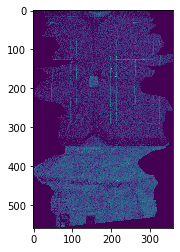

1.3846729

In [171]:
plt.imshow(hw_cubes[0].values[223,:,:])
plt.show()

np.nanmean(hw_cubes[0].values[223,:,:])

In [268]:
res=[]
gdf_test2 = gdf_test.copy()
gdf_test2['geometry'] = gdf_test.to_crs(epsg=3857).buffer(0.5).to_crs(epsg=4326)

for hw_ind in range(3):
    
    print(f'on cube {hw_ind}')
    # create mask datasets for the VNIR and SWIR data separately
    ds_vnir = xr.Dataset(coords={'y':y_vnir_ls[hw_ind], 'x':x_vnir_ls[hw_ind]})
    shapes = [(shape, n) for n, shape in enumerate(gdf_test2.geometry)]

    temp_vnir = []
    for i, shape in enumerate(shapes):

        try:
            ds_vnir['aoi'] = rasterize([shape], ds_vnir.coords)
            ds_vnir['aoi'] = ds_vnir.aoi*0 + 1
            example_vnir = ds_vnir.aoi * xarr_VNIR_ls[hw_ind]

            val_y, val_x = np.where(ds_vnir.aoi==1)
            u_y = np.unique(val_y)
            u_x = np.unique(val_x)
            ex_vnir = example_vnir.sel(y=y_vnir_ls[hw_ind][val_y], x=x_vnir_ls[hw_ind][val_x])

            # cut off the VNIR if provided
            w_cutoff = 896
            if w_cutoff > 0:
                b_cutoff = np.where(ex_vnir.coords['wavelength'] <= w_cutoff)[0][-1] + 1 # +1 due to 1 based indexing on band
                ex_vnir = ex_vnir.sel(band=slice(0, b_cutoff))


            if ex_vnir.shape[0] == 0:
                temp_vnir.append(np.zeros((ex_vnir.shape[-1])))
            else:
                #temp_vnir.append(np.squeeze(ex_vnir)) # for points
                temp_vnir.append(np.nanmean(ex_vnir, axis=(0,1))) # for polygons

        except Exception as e:
            print(e)
            print(val_y, val_x, example_vnir.shape)
            print(f'shape {i} is not in VNIR file')
            print('***')

    #print(temp_vnir)
    vnir_stack = np.vstack(temp_vnir)

    # SWIR
    ds_swir = xr.Dataset(coords={'y':y_swir_ls[hw_ind], 'x':x_swir_ls[hw_ind]})
    shapes = [(shape, n) for n, shape in enumerate(gdf_test2.geometry)]

    temp_swir = []
    for shape in shapes:

        try:
            ds_swir['aoi'] = rasterize([shape], ds_swir.coords)
            ds_swir['aoi'] = ds_swir.aoi*0 + 1
            example_swir = ds_swir.aoi * xarr_SWIR_ls[hw_ind]

            val_y, val_x = np.where(ds_swir.aoi==1)
            u_y = np.unique(val_y)
            u_x = np.unique(val_x)
            ex_swir = example_swir.sel(y=y_swir_ls[hw_ind][val_y], x=x_swir_ls[hw_ind][val_x])

            if ex_swir.shape[0] == 0:
                temp_swir.append(np.zeros((ex_swir.shape[-1])))
            else:
                #temp_swir.append(np.squeeze(ex_swir)) # for points
                temp_swir.append(np.nanmean(ex_swir, axis=(0,1))) # for polygons
        except:
            print(e)
            print(val_y, val_x)
            print('shape is not in SWIR file')

    swir_stack = np.vstack(temp_swir)

    # concatenate the data
    full_ex = np.hstack((vnir_stack, swir_stack))


    # concatenate the wavelength vectors
    full_wav = np.concatenate((ex_vnir.coords['wavelength'].values, ex_swir.coords['wavelength'].values))
    full_wav = np.unique(full_wav)
    
    res.append((full_ex, full_wav)) # for points
    

on cube 0
on cube 1
on cube 2


In [276]:
gdf_test.comments

0        dirt parking lot
1    tennis court (south)
2                 red hut
3     grass patch (south)
4           leaf off tree
Name: comments, dtype: object

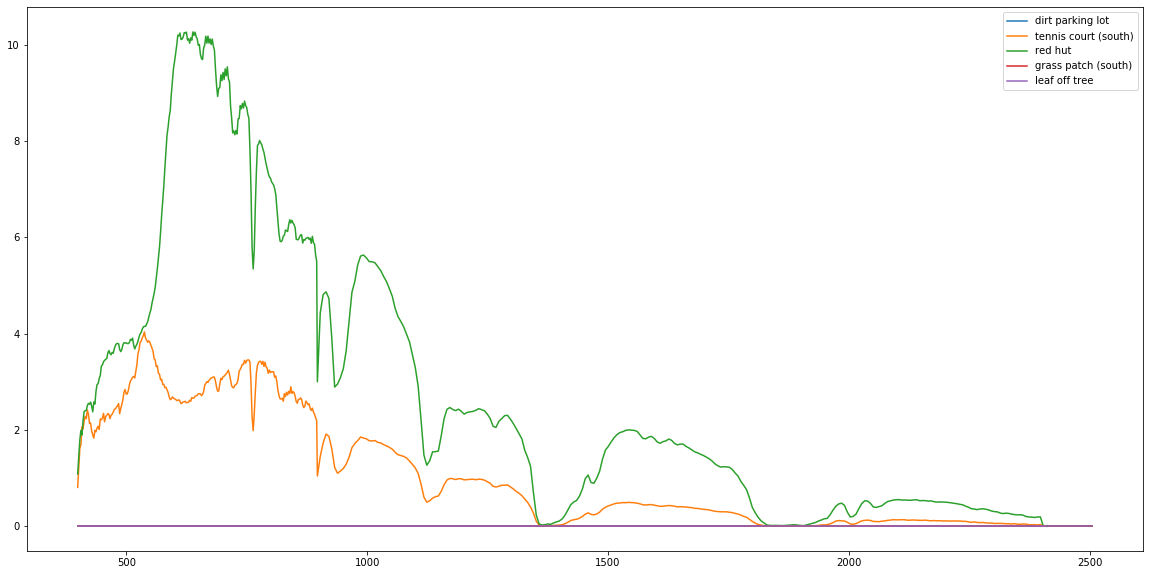

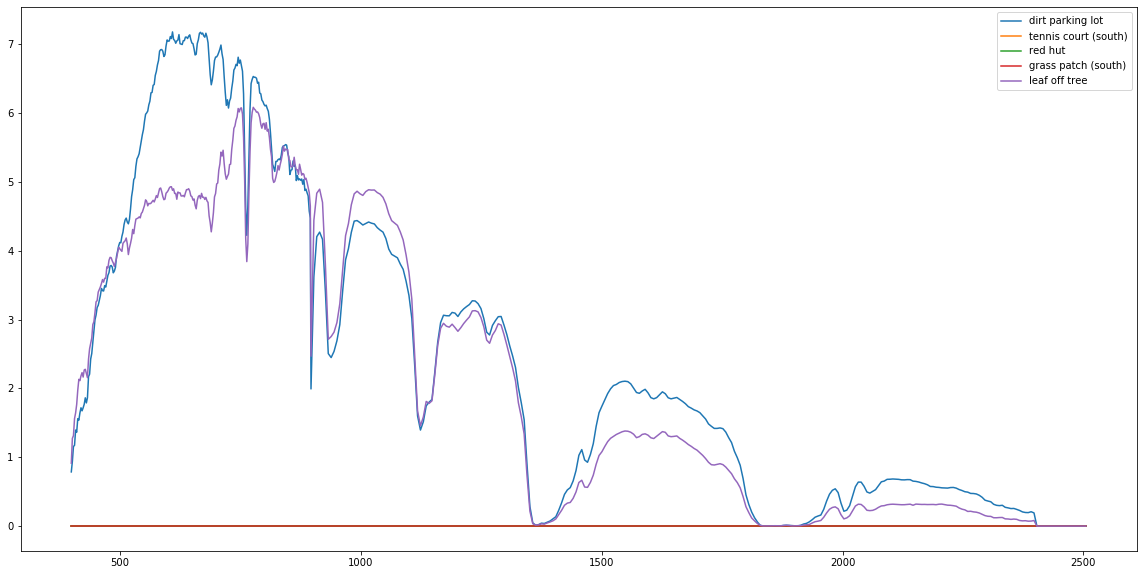

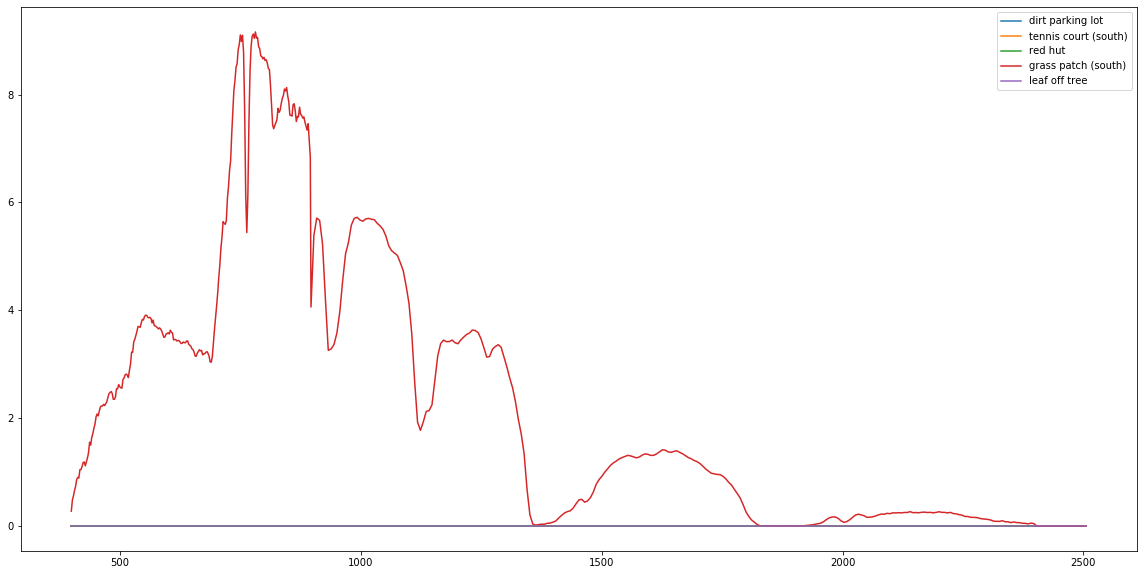

In [270]:
for r in res:
    plt.figure(figsize=(20,10))
    for i, em in enumerate(r[0]):
        plt.plot(r[1], em, label=gdf_test.comments[i])
    plt.legend()
    plt.show()

In [304]:
from collections import OrderedDict

# reduce endmembers since there are 3 'sets'
U_hw = []
for r in res:
    
    for i, em in enumerate(r[0]):
        if em.sum() > 0:
            U_hw.append((gdf_test.comments[i], em))
                    
U_hw_dict = OrderedDict(U_hw)

In [305]:
# resort the HW endmembers to match the original geodataframe
ix = [gdf_test2.where(gdf_test2.comments == k).dropna().index[0] for k in U_hw_dict.keys()]
ivals = [gdf_test2.loc[gdf_test2.comments == k].comments.iloc[0] for k in gdf_test2.comments]

for k in ivals: # a loop to force the order you want
    U_hw_dict.move_to_end(k)

ivals, ix, gdf_test2.comments.values, U_hw_dict.keys()

(['dirt parking lot',
  'tennis court (south)',
  'red hut',
  'grass patch (south)',
  'leaf off tree'],
 [1, 2, 0, 4, 3],
 array(['dirt parking lot', 'tennis court (south)', 'red hut',
        'grass patch (south)', 'leaf off tree'], dtype=object),
 odict_keys(['dirt parking lot', 'tennis court (south)', 'red hut', 'grass patch (south)', 'leaf off tree']))

In [306]:
U_hw_arr = []
for h in U_hw_dict:
    U_hw_arr.append(U_hw_dict[h])
    
U_hw_arr = np.array(U_hw_arr)

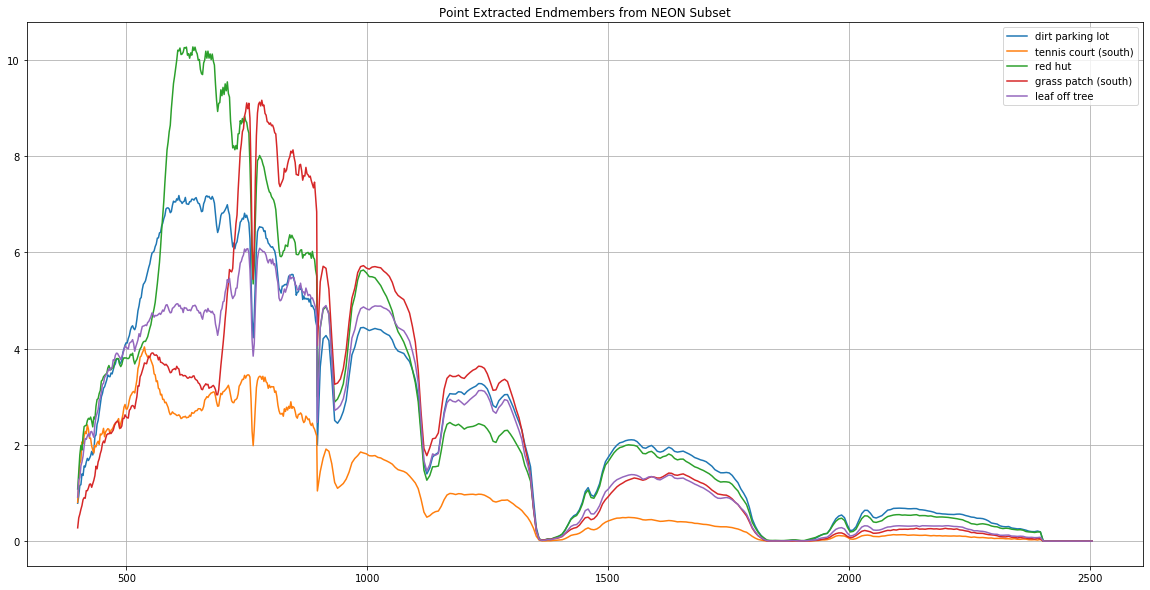

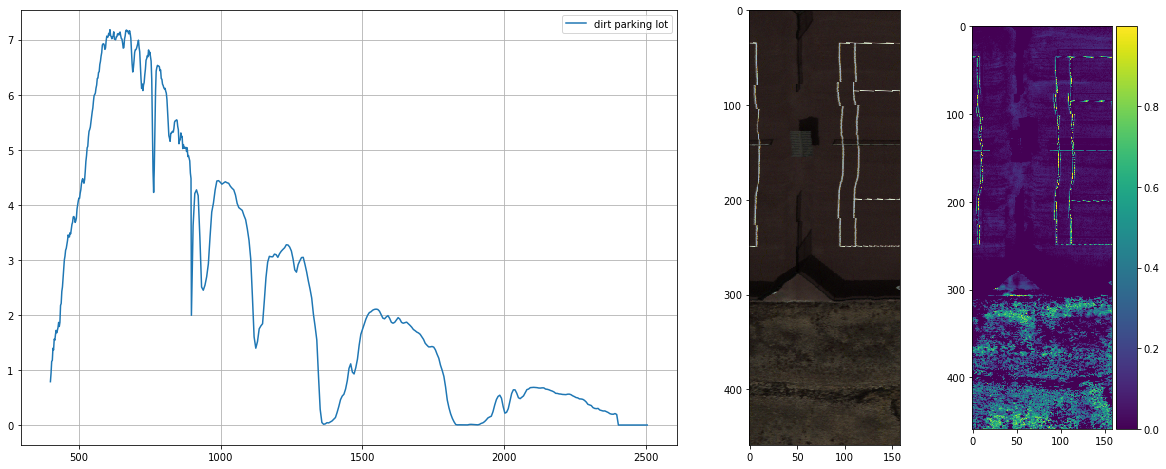

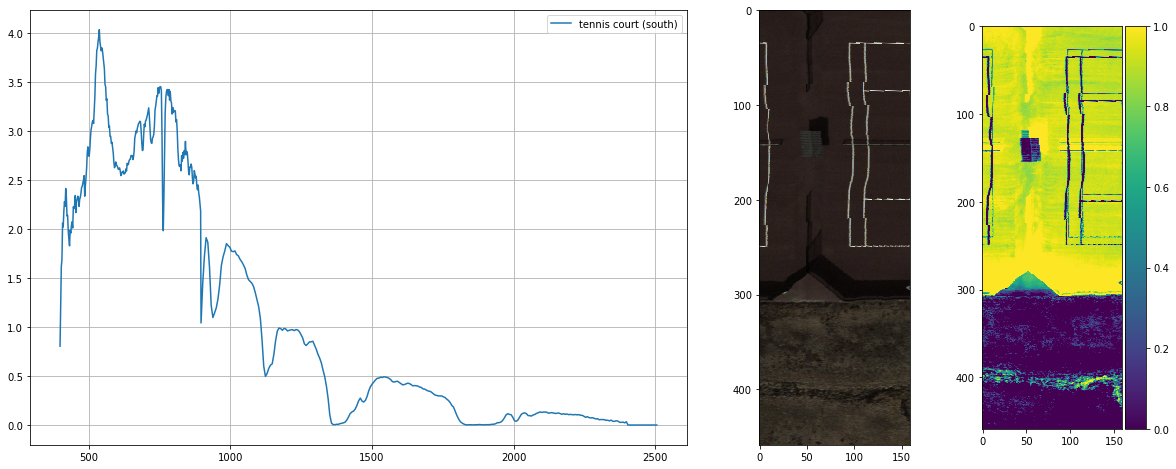

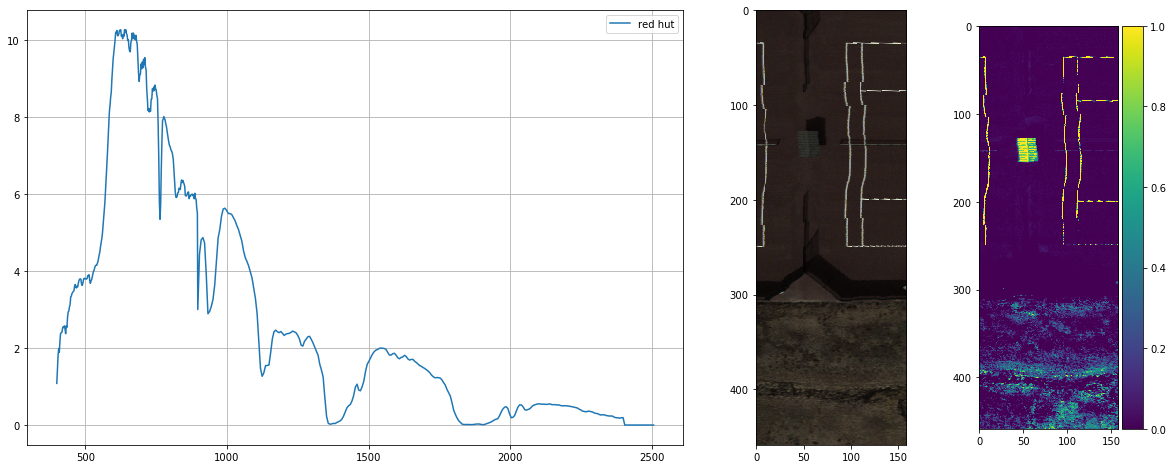

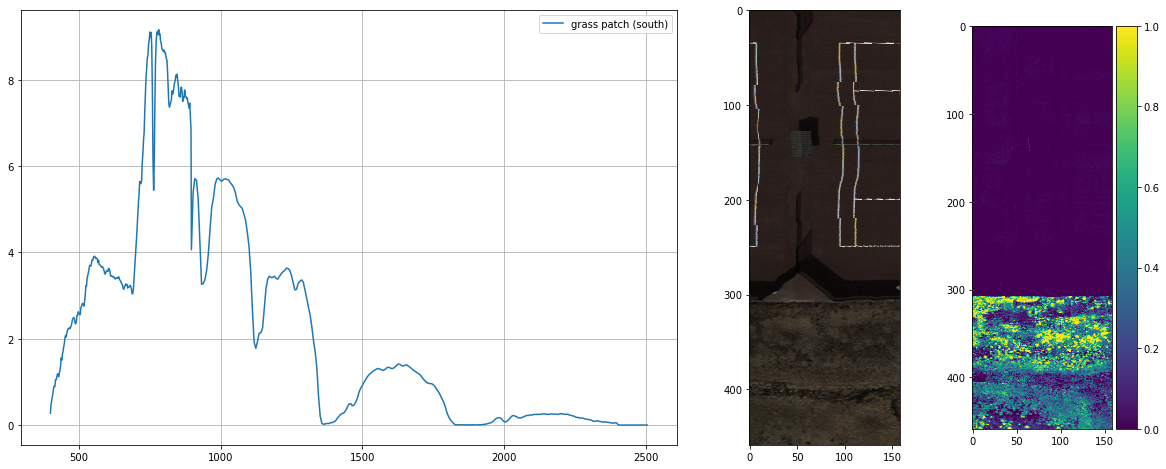

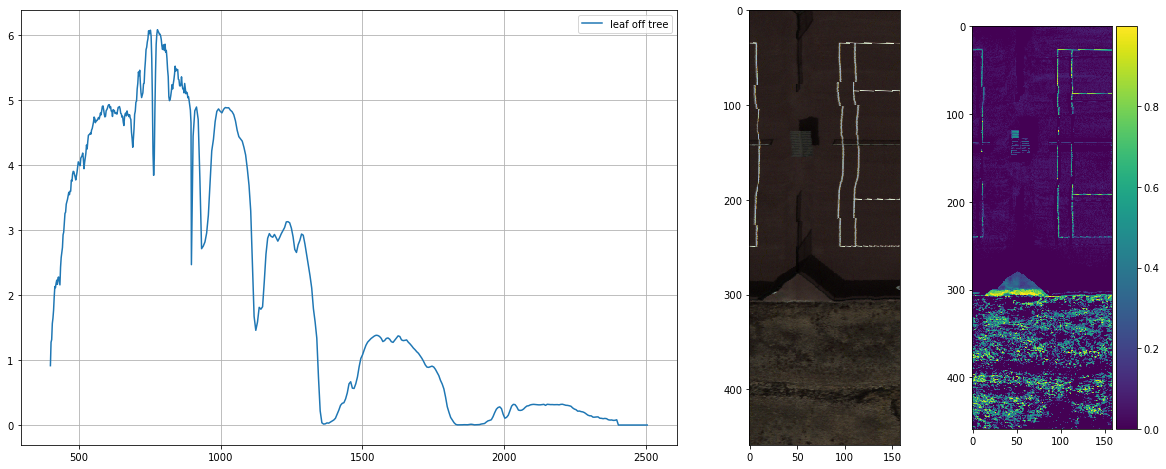

*****************************************************************************
*****************************************************************************
*****************************************************************************
*****************************************************************************


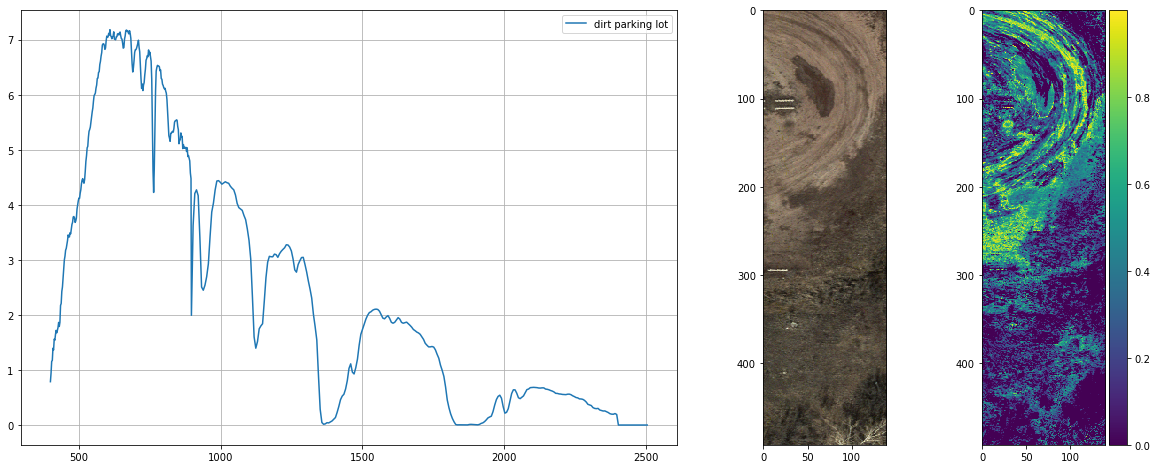

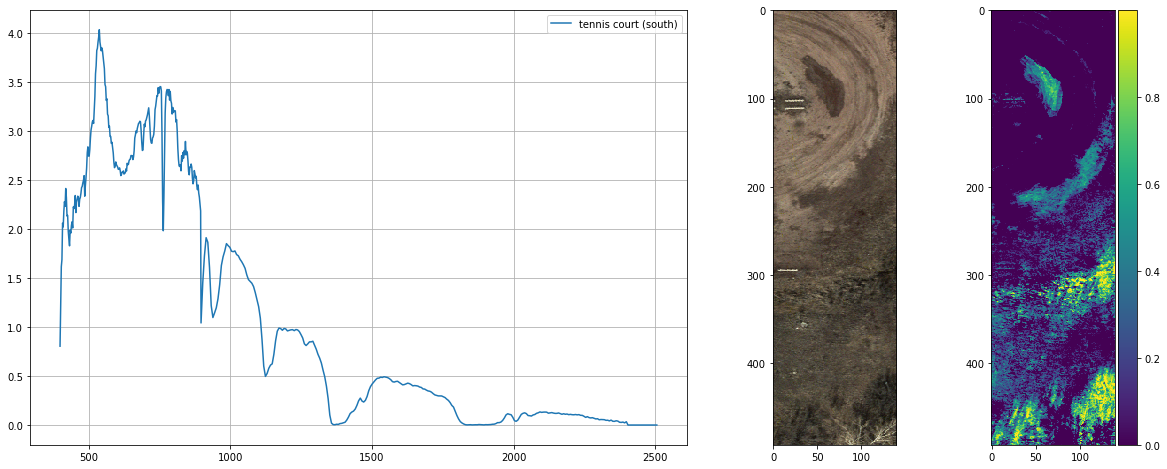

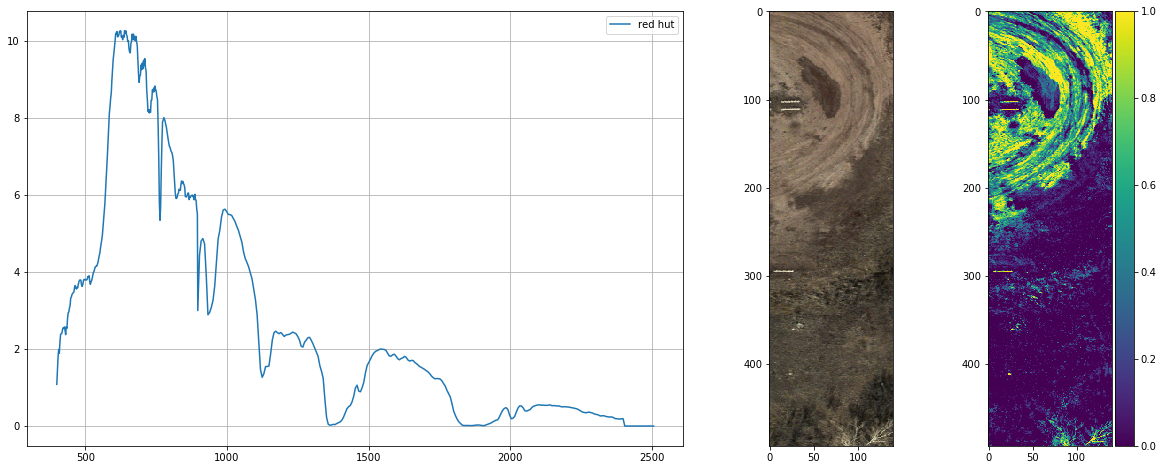

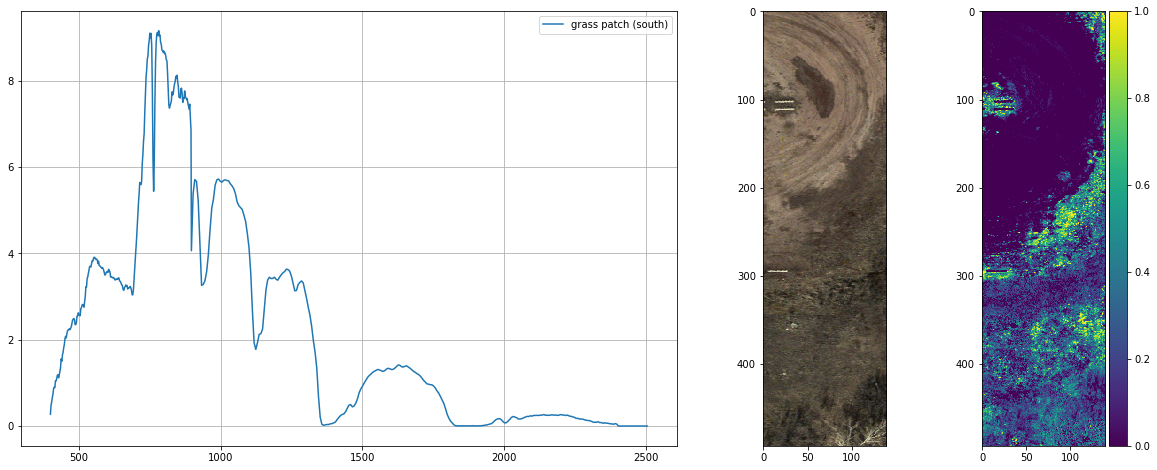

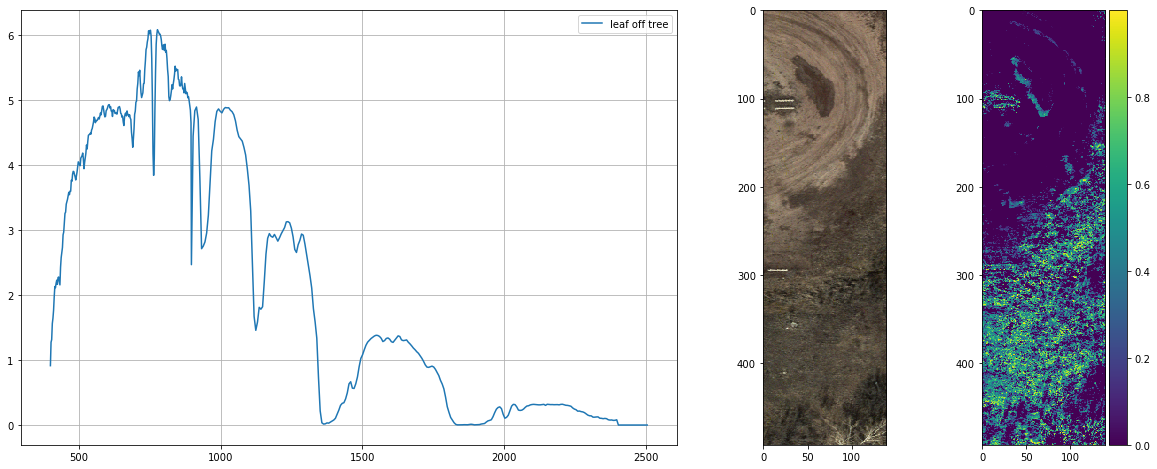

*****************************************************************************
*****************************************************************************
*****************************************************************************
*****************************************************************************


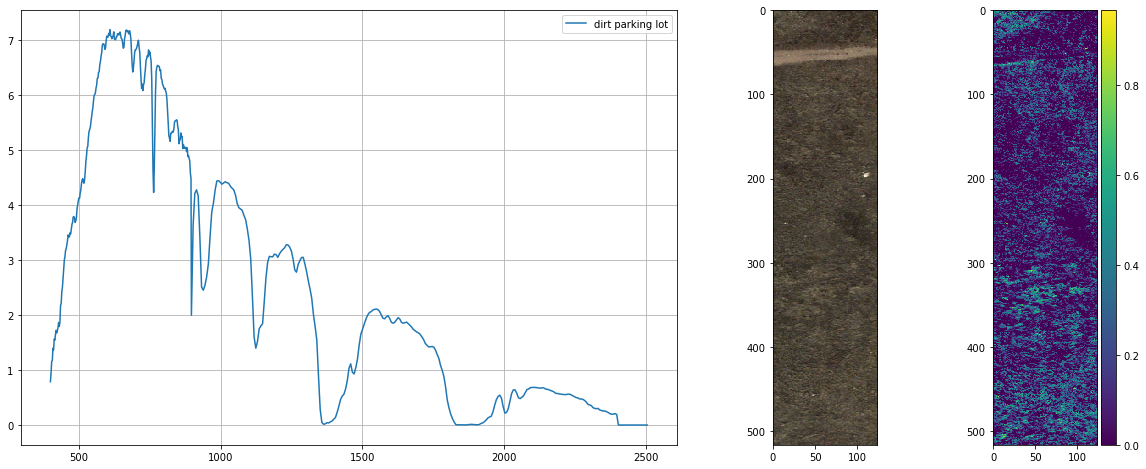

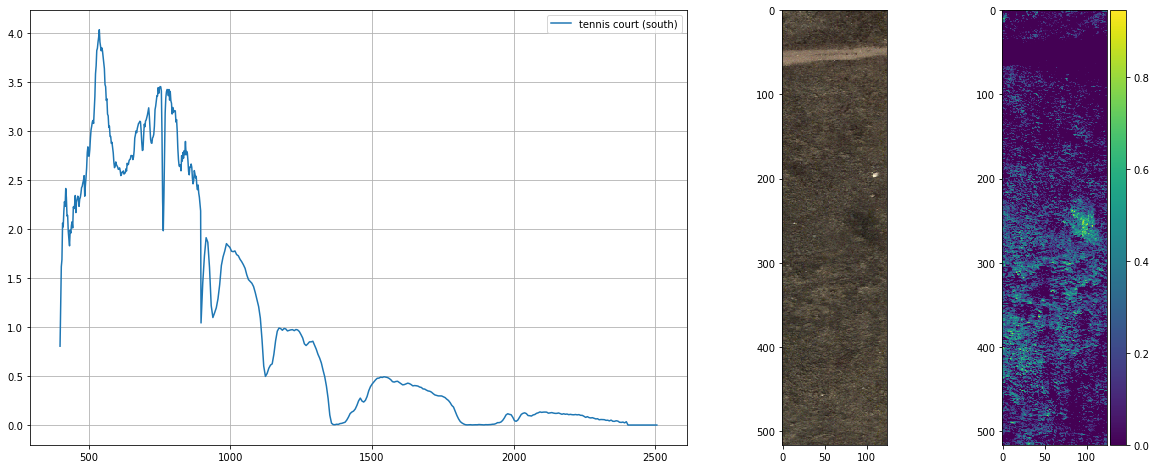

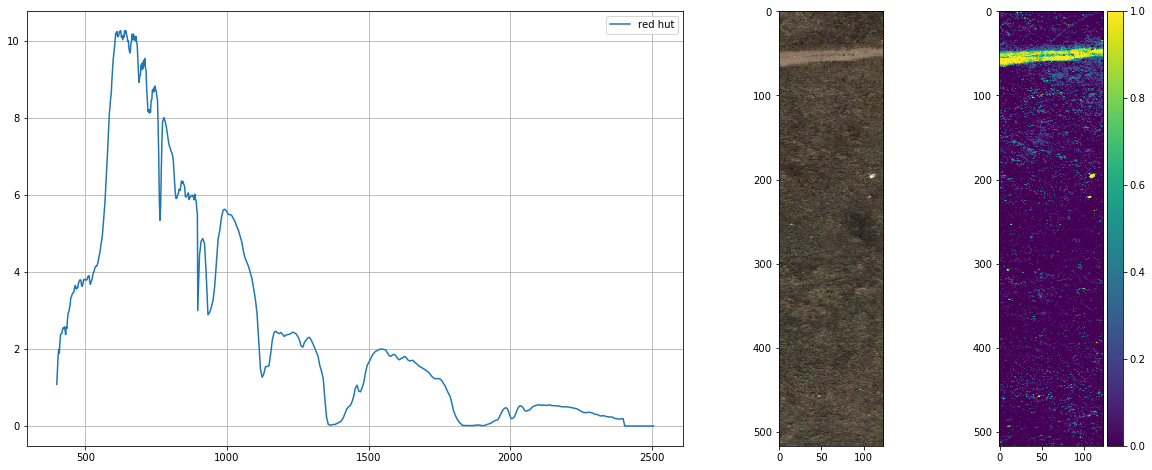

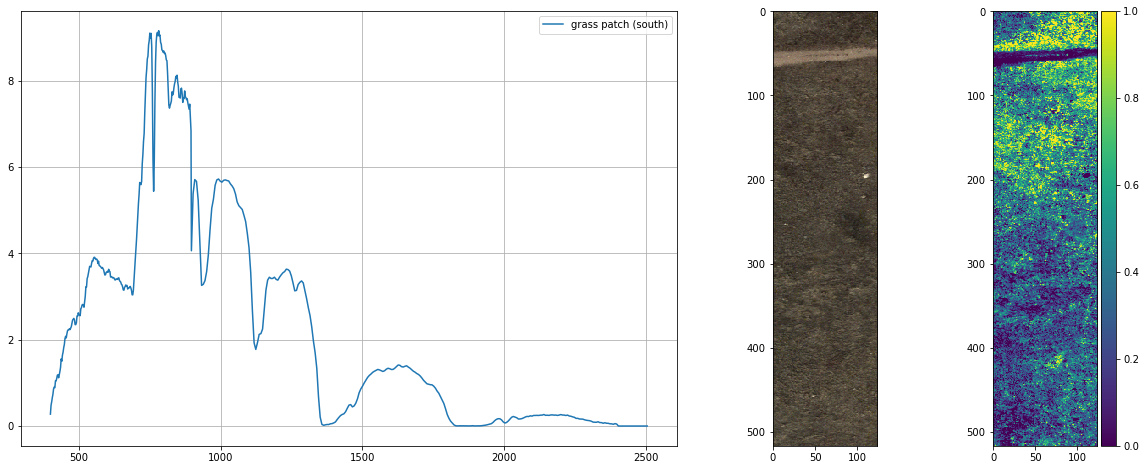

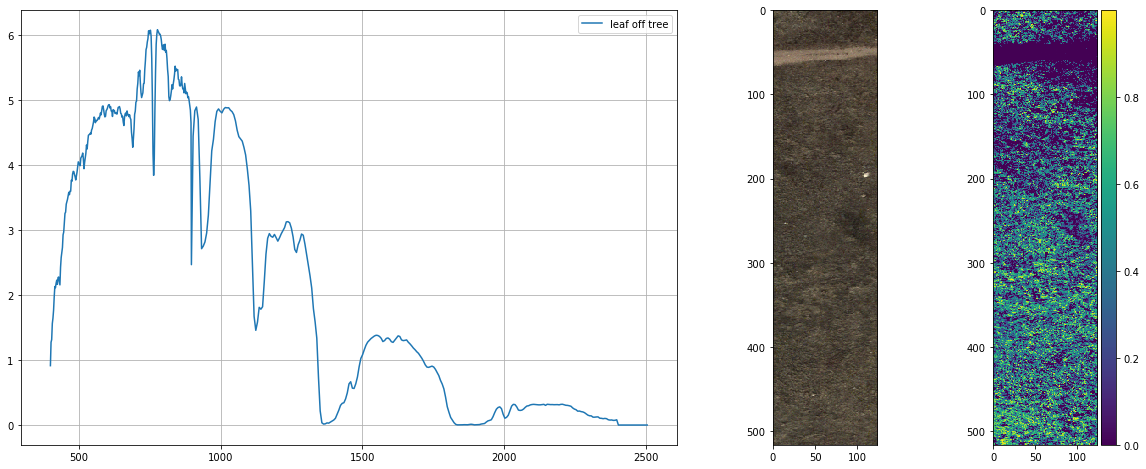

*****************************************************************************
*****************************************************************************
*****************************************************************************
*****************************************************************************


In [307]:
# plot them
hw_wav = res[0][1]
plt.figure(figsize=(20,10))
for h in U_hw_dict:
    plt.plot(hw_wav, U_hw_dict[h], label=h)

plt.title(f'Point Extracted Endmembers from NEON Subset')
plt.legend()
plt.grid(True)
plt.show()

for j in range(3):
    # Plot the abundance maps
    am2 = amap.FCLS()
    # am2 = amap.NNLS()
    # test_plot = hw_cubes[0].transpose('y', 'x', 'band').values[200:-250,100:200,:]
    # test_plot = np.rollaxis(hw_cubes[0].values[:,200:-250,190:220], 0, 3)
    test_plot = np.rollaxis(hw_cubes[j].values[:,50:-50,100:-100], 0, 3)
    # test_plot =  np.rollaxis(hw_cubes[0].values, 0, 3)
    test_plot[~np.isfinite(test_plot)] = 0
    ab_maps = am2.map(test_plot, U_hw_arr, normalize=False)
                     #mask=(hw_cubes[0].transpose('y', 'x', 'band').values == 0)[:,:,0])

    for i,h in enumerate(U_hw_dict):
        fig = plt.figure(figsize=(20,8))
        gs = gridspec.GridSpec(1, 3, width_ratios=[4, 1, 1]) 

        ax0 = plt.subplot(gs[0])
        p0 = ax0.plot(hw_wav, U_hw_dict[h], label=h)
        ax0.legend()
        ax0.grid(True)

        ax1 = plt.subplot(gs[1])
        im1 = ax1.imshow(bytescale(test_plot[:,:,[54, 34, 22]]))

        ax2 = plt.subplot(gs[2])
        im2 = ax2.imshow(ab_maps[:,:,i])


        divider = make_axes_locatable(ax2)
        cax = divider.append_axes("right", size="15%", pad=0.05)

        plt.colorbar(im2, cax=cax)
        plt.show()

    print('*****************************************************************************')
    print('*****************************************************************************')
    print('*****************************************************************************')
    print('*****************************************************************************')

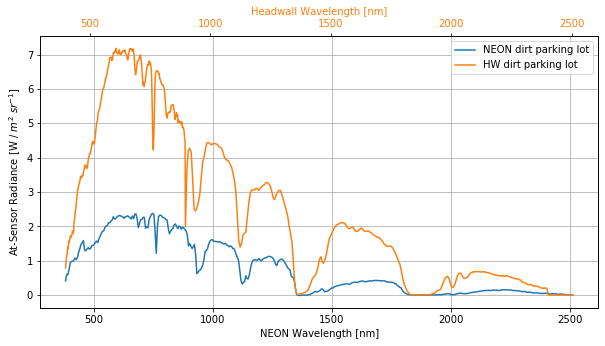

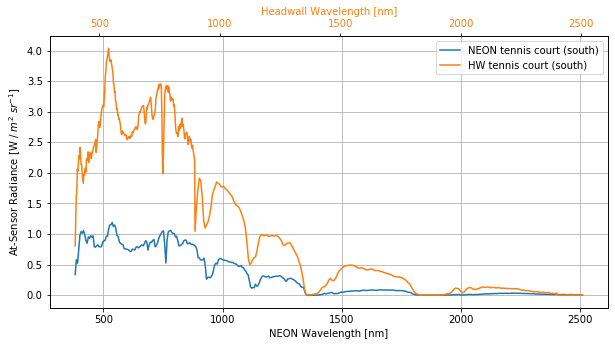

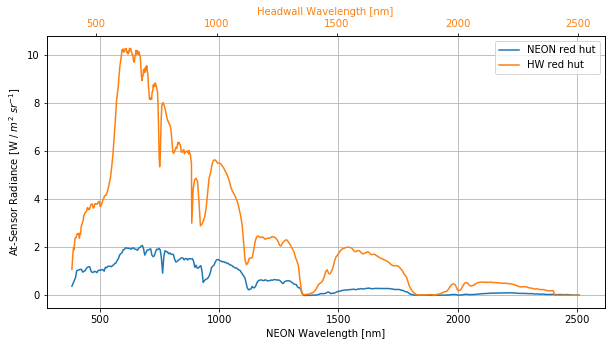

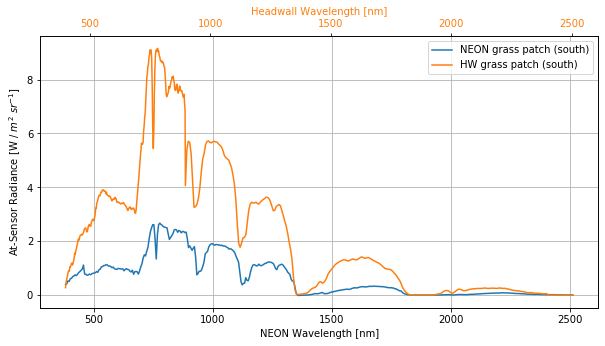

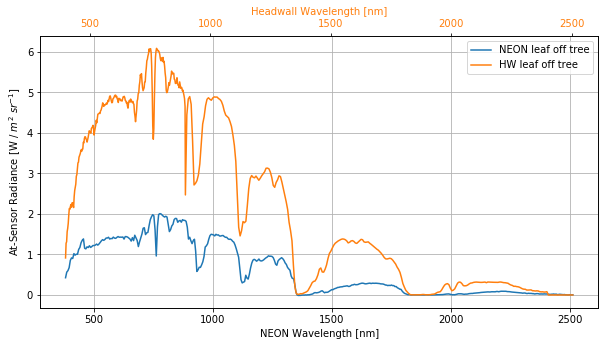

In [333]:
# plot the endmembers against each other
i=0
for em_n, em_h,k in zip(Ue, U_hw_dict.values(), U_hw_dict.keys()):
    
    fig, ax1 = plt.subplots(figsize=(10,5))
    
    l1 = ax1.plot(neon_wav, em_n, label=f'NEON {k}')
    ax1.set_xlabel('NEON Wavelength [nm]')
    ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis

    color = 'tab:orange'
    ax2.set_xlabel('Headwall Wavelength [nm]', color=color)  # we already handled the x-label with ax1
    l2 = ax2.plot(full_wav, em_h, color=color, label=f'HW {k}')
    ax2.tick_params(axis='x', labelcolor=color)
    
    #plt.plot(em_h, label=f'hw {k}')
    
    #ax1.legend()
    #ax2.legend(loc=3)
    
    lns = l1 + l2
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs, loc=0)
    
    ax1.grid(True)
    #plt.xlabel('Wavelength [nm]')
    ax1.set_ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
    #plt.grid(True)
    plt.show()
    
    i+=1

# next thing... Subset NEON cube by each headwall cube and unmix. First with NEON endmembers and then with Headwall endmembers.

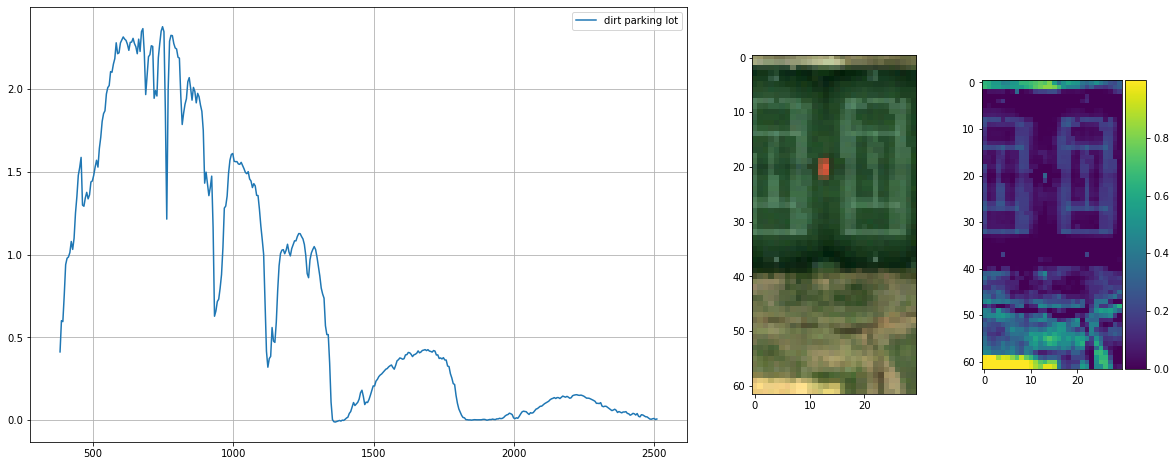

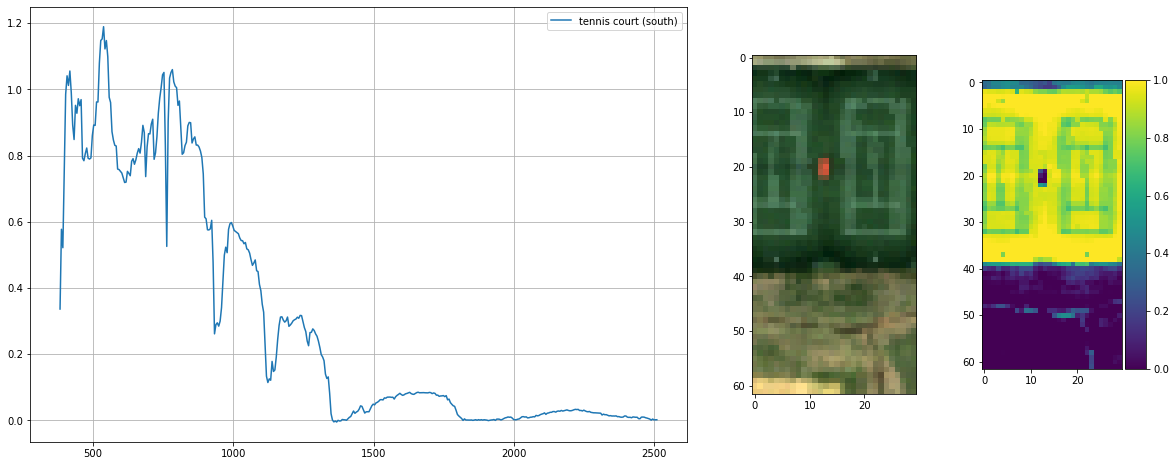

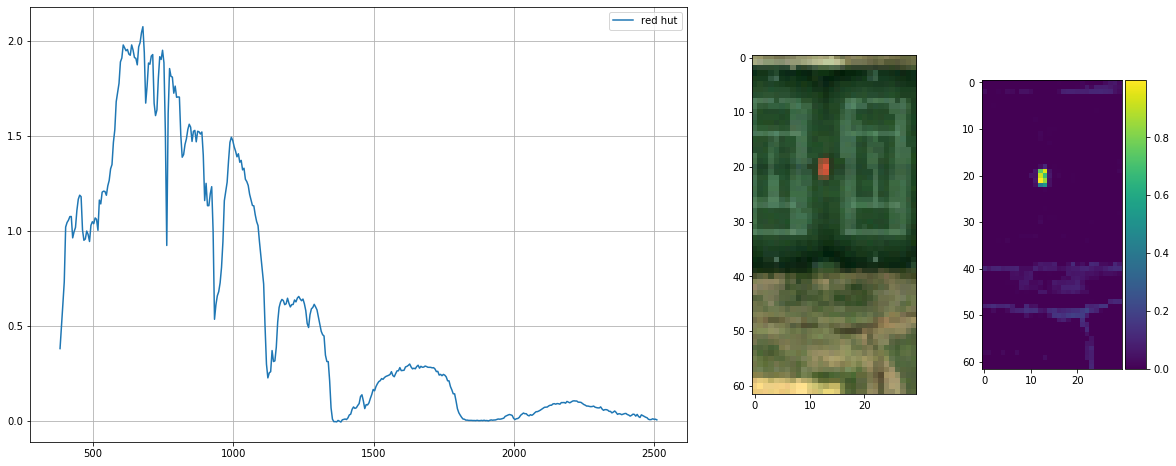

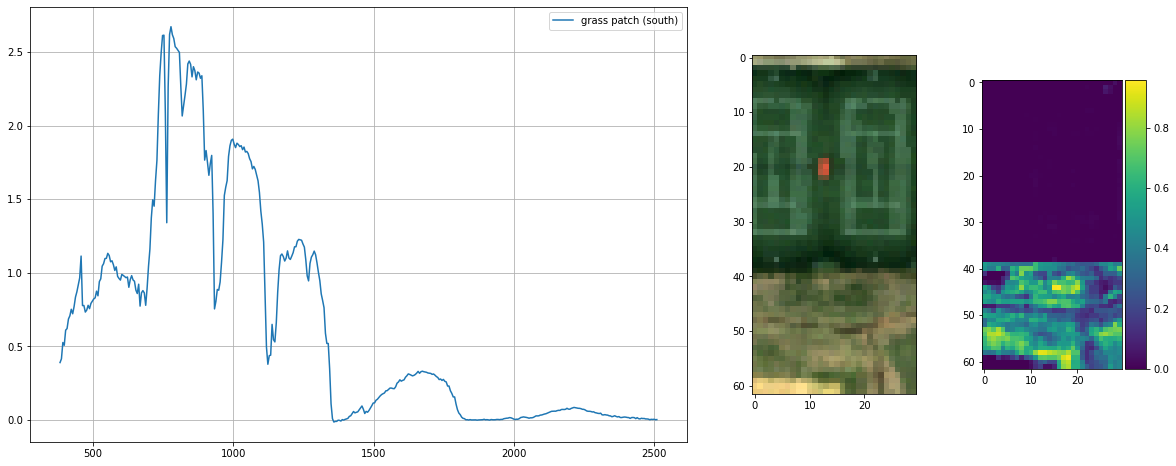

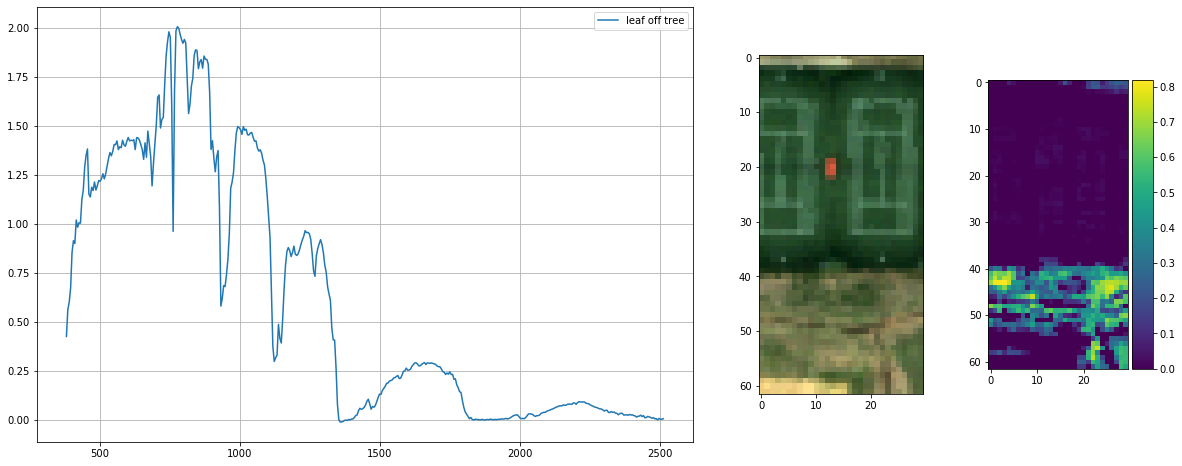

*****************************************************************************
*****************************************************************************
*****************************************************************************
*****************************************************************************


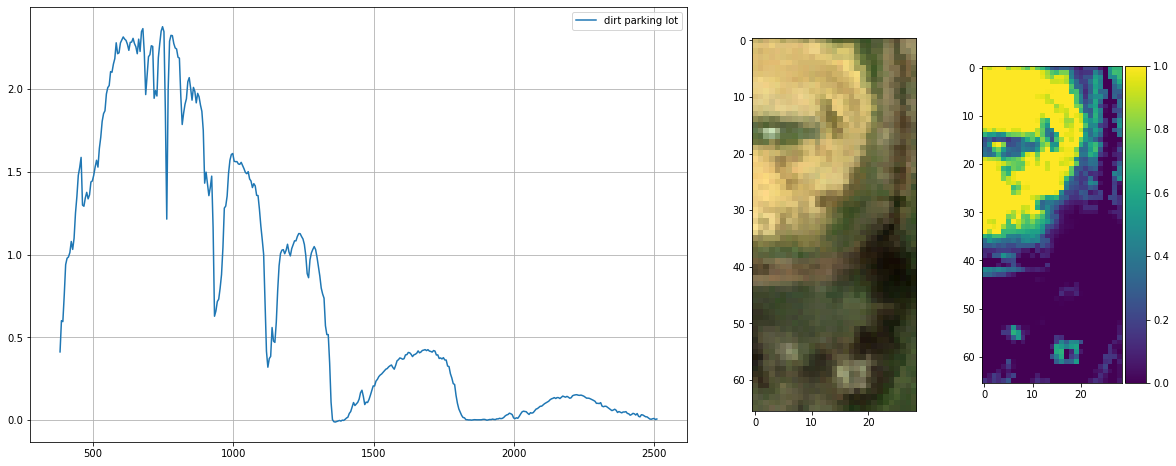

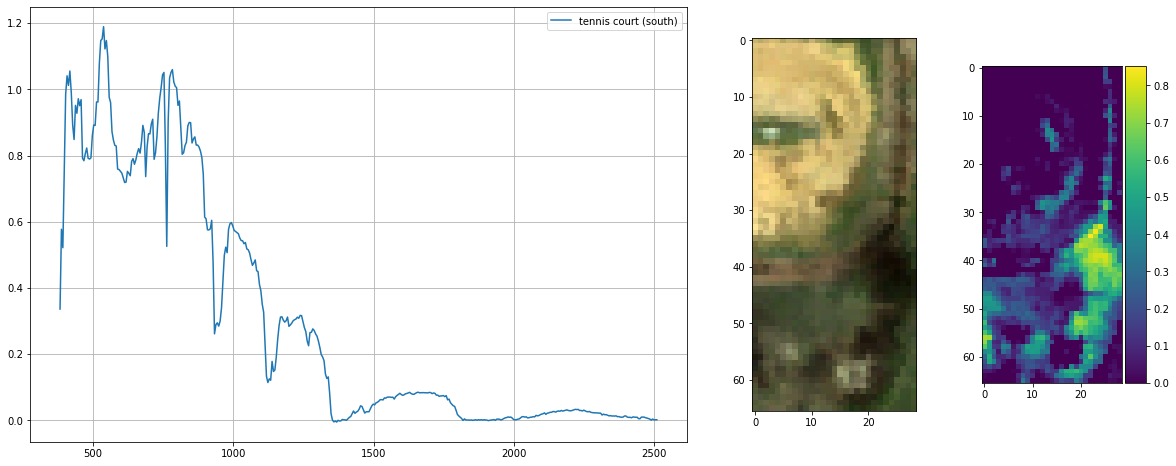

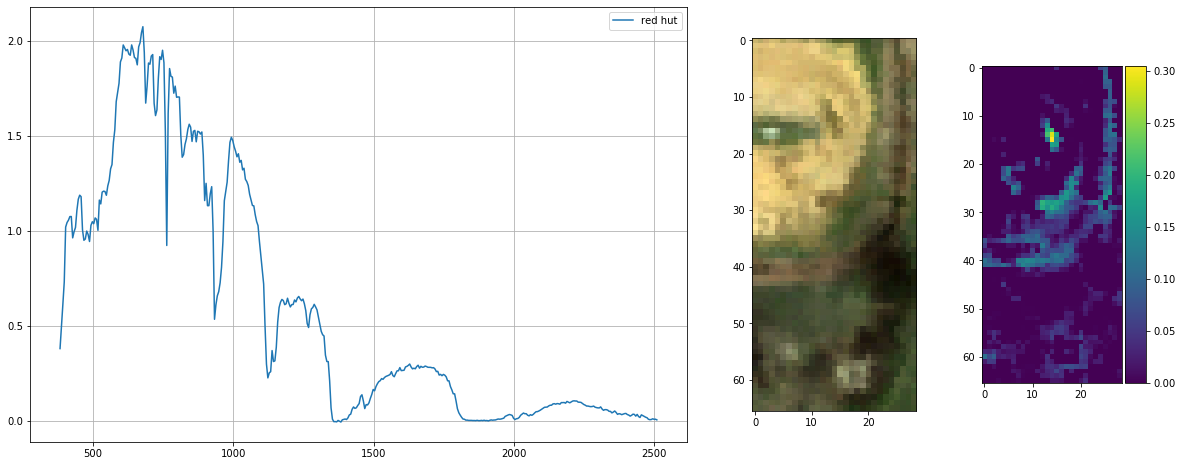

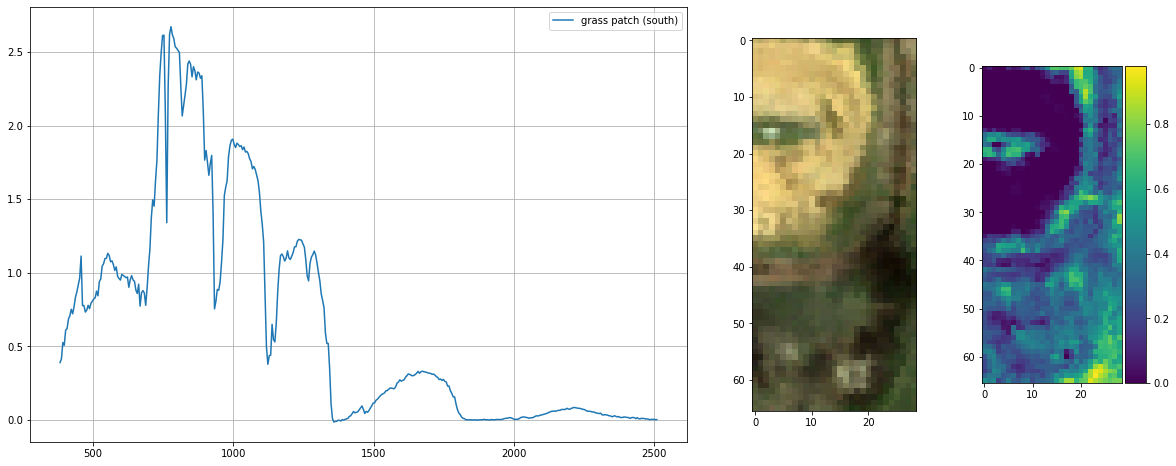

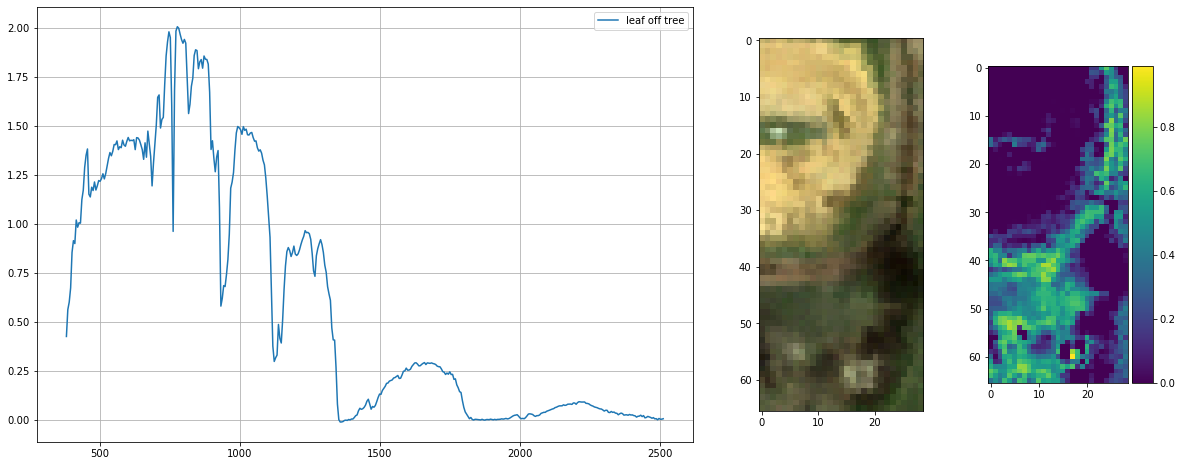

*****************************************************************************
*****************************************************************************
*****************************************************************************
*****************************************************************************


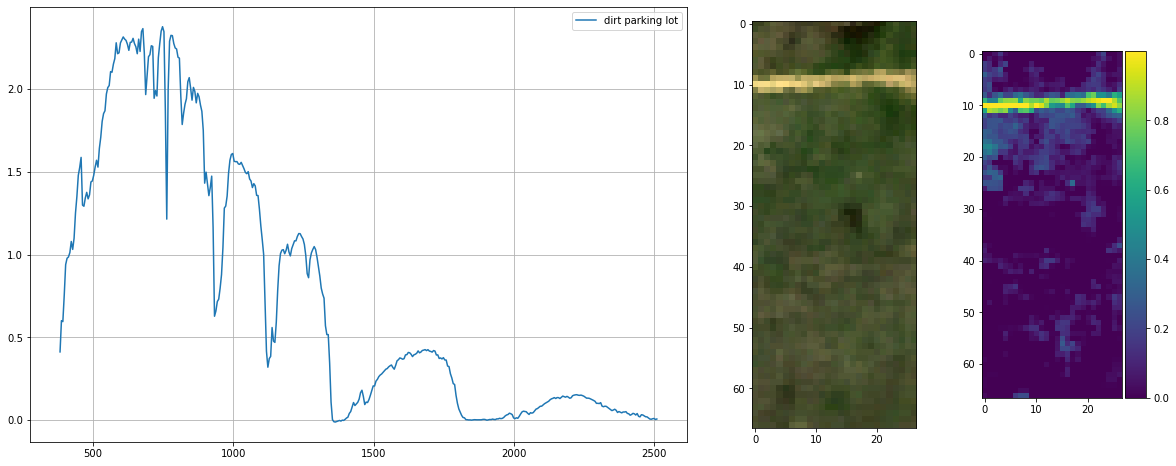

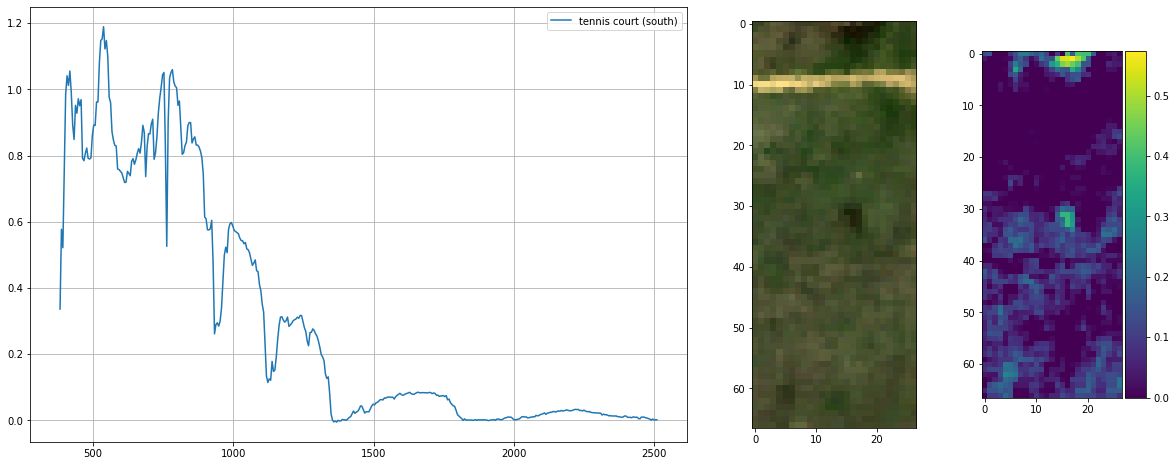

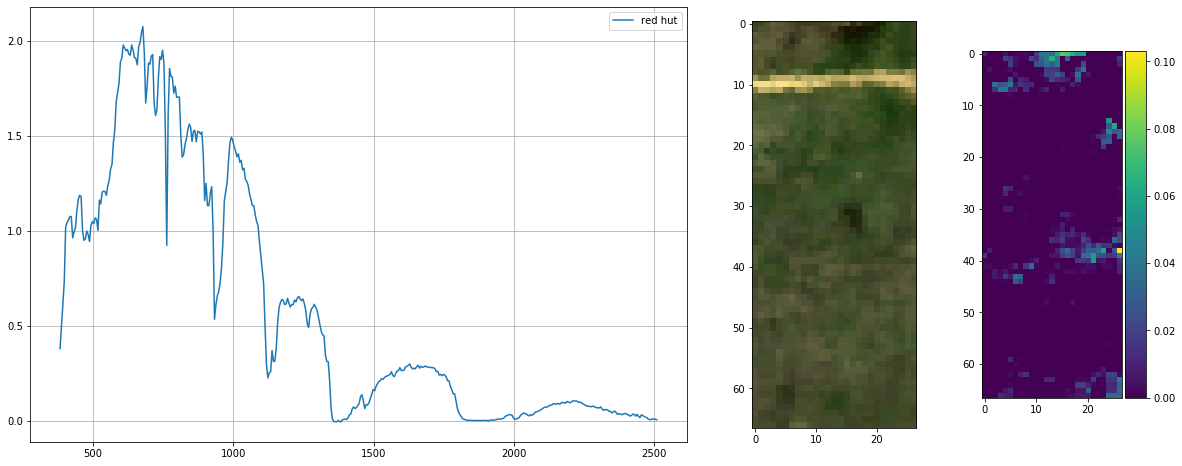

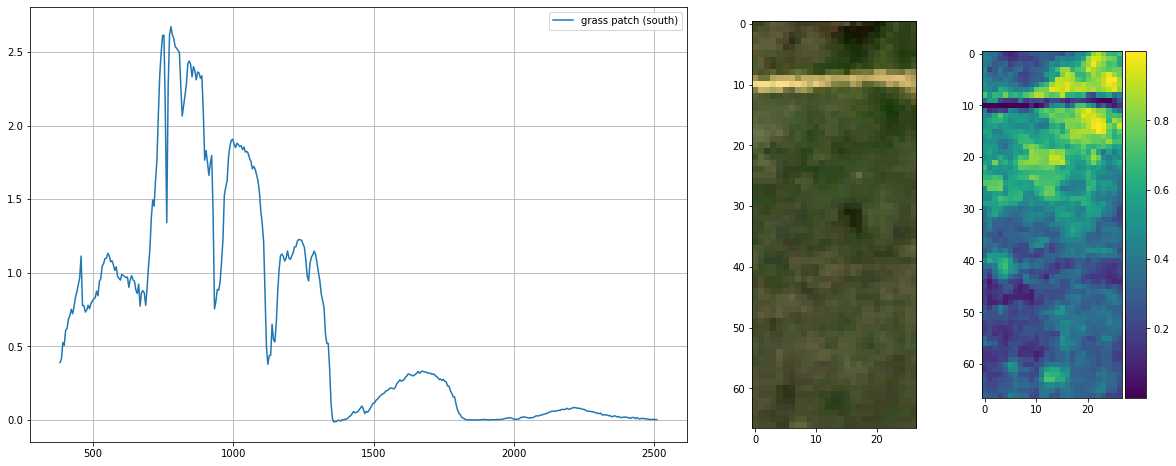

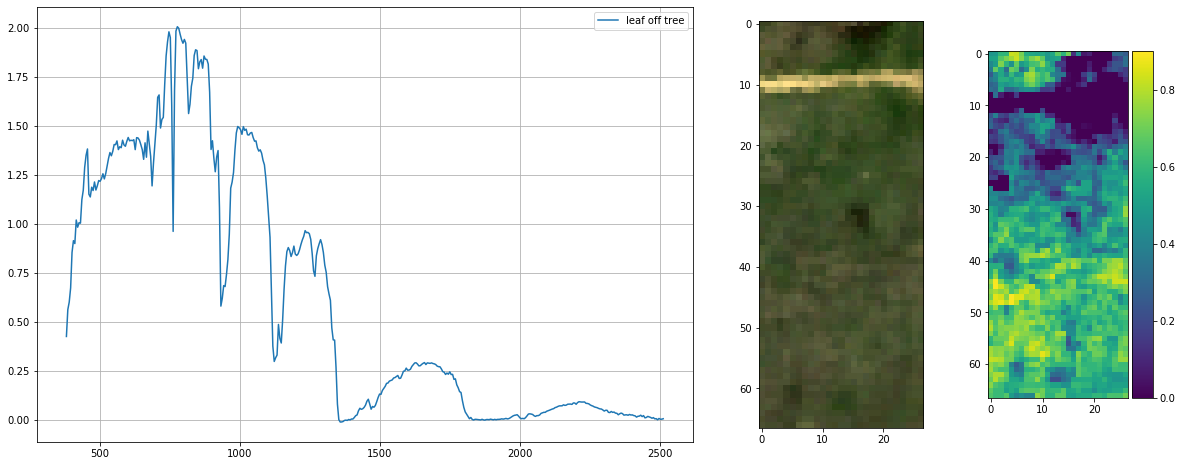

*****************************************************************************
*****************************************************************************
*****************************************************************************
*****************************************************************************


In [343]:
# subset the NEON data with the full extent of headwall data cubes
j=0
for x,y in zip(x_vnir_ls, y_vnir_ls):
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    
    bbox = box(xmin, ymin, xmax, ymax)
    chunk1 = gpd.GeoDataFrame({'geometry':[bbox]}, crs=fiona.crs.from_epsg(4326)).to_crs(epsg=32613)

    neon_sub_cube, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), chunk1)
    neon_wav, full_neon = neon_arrs
    
    if j==2:
        neon_sub_cube=neon_sub_cube[1:,1:,:]
        
    # Plot the abundance maps
    am = amap.FCLS()
    ab_maps = am.map(neon_sub_cube.values, Ue, normalize=False)

    for i,em in enumerate(Ue):
        fig = plt.figure(figsize=(20,8))
        gs = gridspec.GridSpec(1, 3, width_ratios=[4, 1, 1]) 

        ax0 = plt.subplot(gs[0])
        p0 = ax0.plot(neon_wav, em, label=gdf.comments[i])
        ax0.legend()
        ax0.grid(True)

        ax1 = plt.subplot(gs[1])
        im1 = ax1.imshow(bytescale(neon_sub_cube.values[:,:,[54, 34, 22]]))

        ax2 = plt.subplot(gs[2])
        im2 = ax2.imshow(ab_maps[:,:,i])


        divider = make_axes_locatable(ax2)
        cax = divider.append_axes("right", size="15%", pad=0.05)

        plt.colorbar(im2, cax=cax)
        plt.show()

    print('*****************************************************************************')
    print('*****************************************************************************')
    print('*****************************************************************************')
    print('*****************************************************************************')
    
    j+=1

In [342]:
# test for nans if above erros out
r,c,b=np.where(~np.isfinite(neon_sub_cube.values))
np.unique(r), np.unique(c), np.unique(b)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21], dtype=int64),
 array([0], dtype=int64),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151,

# scribbles


In [ ]:
# need to update helper functions to do this processing if geometries are POINTS
ds_neon = xr.Dataset(coords={'y':y_neon, 'x':x_neon})
shapes = [(shape, n) for n, shape in enumerate(gdf.geometry)]

temp=[]
for shape in shapes:
    ds_neon['aoi'] = rasterize([shape], ds_neon.coords)
    ds_neon['aoi'] = ds_neon.aoi*0 + 1

    example_neon = ds_neon.aoi * xarr_NEON

    val_y, val_x = np.where(ds_neon.aoi==1)
    u_y = np.unique(val_y)
    u_x = np.unique(val_x)
    ex_neon = example_neon.sel(y=y_neon[val_y], x=x_neon[val_x])

    temp.append(ex_neon)
    
# ex_neon.shape, ds_neon['aoi'].shape, example_neon.shape

In [ ]:
from shapely.geometry.point import Point
type(gdf.geometry[0]) is Point

In [ ]:
import pandas as pd


In [ ]:
gps_fi = r"D:\projects\headwall_neon\headwall_data\imu_gps_TM1.txt"
gps_df = pd.read_csv(gps_fi, delimiter='\t')
gps_df.head()

In [ ]:
gps_df['Gps_UTC_Date&Time'].dtype

In [ ]:
# gps_df.plot(y='Gps_UTC_Date&Time')
gps_df.plot(y='Alt', x='Timestamp')

In [ ]:
gps_fi2 = r"D:\projects\headwall_neon\headwall_data\imu_gps_TM2.txt"
gps_df2 = pd.read_csv(gps_fi2, delimiter='\t')
gps_df2.plot(y='Alt', x='Timestamp')

In [ ]:
p1 = gps_df.plot(y='Alt', x='Timestamp', label='flight1')
gps_df2.plot(y='Alt', x='Timestamp', ax=p1, label='flight2')
plt.show()

In [ ]:
hw_wav_ls, full_hw_ls = [], []
for xarr_VNIR, x_vnir, y_vnir, xarr_SWIR, x_swir, y_swir in zip(xarr_VNIR_ls, x_vnir_ls, y_vnir_ls, xarr_SWIR_ls, x_swir_ls, y_swir_ls):
    
    ## do the extraction
    hw_vnir_cube, hw_swir_cube, hw_arrs = extract_from_headwall_ENVI((xarr_VNIR, x_vnir, y_vnir), 
                                                                    (xarr_SWIR, x_swir, y_swir), 
                                                                    pt_df_hw,
                                                                    w_cutoff = 896) #896 is start of SWIR wavelength

    full_wav, full_ex = hw_arrs
    
    hw_wav_ls.append(full_wav)
    full_hw_ls.append(full_ex)

# neon flightlines
neon_wav_ls, full_neon_ls = [],[]
for xarr_NEON, x_neon, y_neon in zip(xarr_NEON_ls, x_neon_ls, y_neon_ls):
    neon_sub_cube, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), pt_df_neon)
    neon_wav, full_neon = neon_arrs
    
    neon_wav_ls.append(neon_wav)
    full_neon_ls.append(full_neon)